## (05) Création des visualisations

In [1]:
import os, pandas as pd, numpy as np, matplotlib, matplotlib.pyplot as plt

---

#### Connexion à la base de données

In [2]:
from sqlalchemy import create_engine

In [3]:
user = 'postgres'
password = os.environ.get('pg_psw')
host = 'localhost'
port = '5432'
dbname = 'db_exac'  

engine = create_engine(f"postgresql://{user}:{password}@{host}:{port}/{dbname}")

---

### _00 - Comparaison entre les 7 marques les plus représentées et le statut de leurs produits_

##### En stock = In Stock, Yes, yes, TRUE, 7 available, 32 available
##### Pas en stock = Out of Stock, Sold, No, FALSE
##### En attente de livraison = More on the Way
##### Non défini = Undefined
##### Sur commande = Special Order
##### Produit arrêté = Retired
##### Inconnu = None

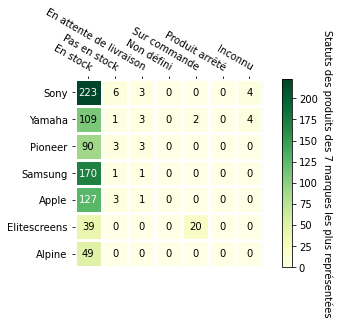

In [4]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

fig, ax = plt.subplots()

Marques = ["Sony", "Yamaha", "Pioneer", "Samsung",
              "Apple", "Elitescreens", "Alpine"]
Statut = ["En stock", "Pas en stock", "En attente de livraison",
           "Non défini", "Sur commande", "Produit arrêté", "Inconnu"]

harvest = np.array([[223, 6, 3, 0, 0, 0, 4],
                    [109, 1, 3, 0, 2, 0, 4],
                    [90, 3, 3, 0, 0, 0, 0],
                    [170, 1, 1, 0, 0, 0, 0],
                    [127, 3, 1, 0, 0, 0, 0],
                    [39, 0, 0, 0, 20, 0, 0],
                    [49, 0, 0, 0, 0, 0, 0]])

im, cbar = heatmap(harvest, Marques, Statut, ax=ax,
                   cmap="YlGn", cbarlabel="Statuts des produits des 7 marques les plus représentées")
texts = annotate_heatmap(im, valfmt="{x}")

fig.tight_layout()
plt.savefig('./Snaps/Plot_15.jpg', bbox_inches = 'tight', transparent=True)
plt.show()

---

### _01 - 10 articles avec le plus de reviews_

In [5]:
query_01 = pd.read_sql_query("""SELECT a.name as "Produit", COUNT(b.rating) AS "Nombre d'avis" 
                             FROM product a 
                             LEFT JOIN reviews b ON a.product_id = b.product_id 
                             GROUP BY a.name
                             ORDER BY "Nombre d'avis" DESC
                             LIMIT 10;""", engine)
query_01.head(10)

,Produit,Nombre d'avis
0,Logitech 915-000224 Harmony Ultimate One 15-D...,1604
1,Microsoft Surface Pro 4 Type Cover with Finger...,495
2,Sony SRSXB30/BLK XB30 Portable Wireless Speake...,477
3,Everest Elite 700 Around-Ear Wireless Headphon...,357
4,Slingbox M2,342
5,SAMSUNG 40'' Class FHD (1080P) Smart LED TV (U...,340
6,"Alpine - 6-1/2"" 2-Way Coaxial Car Speakers wit...",260
7,PNY Anarchy 16GB Kit (2x8GB) DDR4 2400MHz (PC4...,191
8,Sony SRSHG1/BLK Hi-Res Wireless Speaker- Charc...,178
9,Sanus VLF410B1 10-Inch Super Slim Full-Motion ...,162


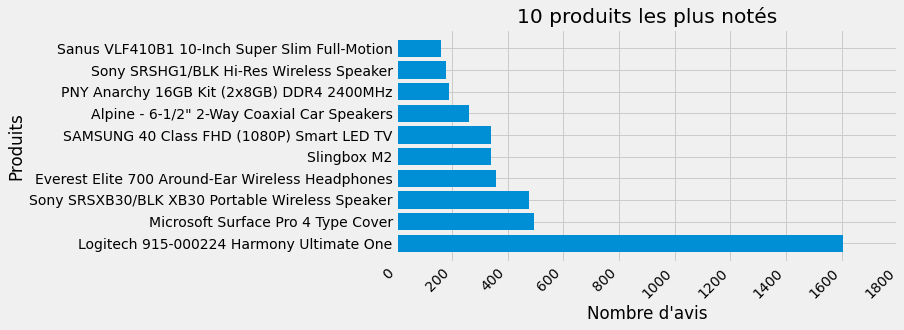

In [6]:
data = {'Logitech 915-000224 Harmony Ultimate One': 1604,
        'Microsoft Surface Pro 4 Type Cover': 495,
        'Sony SRSXB30/BLK XB30 Portable Wireless Speaker': 477,
        'Everest Elite 700 Around-Ear Wireless Headphones': 357,
        'Slingbox M2': 342,
        'SAMSUNG 40'' Class FHD (1080P) Smart LED TV': 340,
        'Alpine - 6-1/2" 2-Way Coaxial Car Speakers': 260,
        'PNY Anarchy 16GB Kit (2x8GB) DDR4 2400MHz': 191,
        'Sony SRSHG1/BLK Hi-Res Wireless Speaker': 178,
        'Sanus VLF410B1 10-Inch Super Slim Full-Motion': 162}

group_data = list(data.values())
group_names = list(data.keys())
group_mean = np.mean(group_data)

plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(figsize=(8, 4))
ax.barh(group_names, group_data)
labels = ax.get_xticklabels()
plt.setp(labels, rotation=45, horizontalalignment='right')
ax.set(xlim=[0, 1800], xlabel="Nombre d'avis", ylabel='Produits',
       title='10 produits les plus notés')

plt.savefig('./Snaps/Plot_01.jpg', bbox_inches = 'tight', transparent=True)

---

### _02 - Produits en promotion ou non_

In [7]:
query_02 = pd.read_sql_query("""SELECT a.issale AS "Produits", COUNT(a.product_id) AS "En promotion"
                                FROM prices a
                                GROUP BY a.issale 
                                ORDER BY "En promotion" DESC
                                LIMIT 10""", engine)
query_02.head()

,Produits,En promotion
0,False,5508
1,True,1741
2,None,50


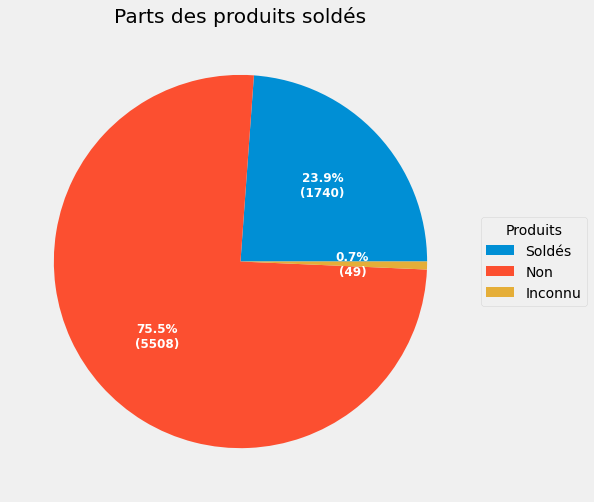

In [8]:
fig, ax = plt.subplots(figsize=(27, 8), subplot_kw=dict(aspect="equal"))

contenu = ["1741 Soldés",
          "5508 Non",
          "50 Inconnu"]

data = [float(x.split()[0]) for x in contenu]
legende = [x.split()[-1] for x in contenu]


def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)


wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))

ax.legend(wedges, legende,
          title="Produits",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=12, weight="bold")

ax.set_title("Parts des produits soldés")

plt.savefig('./Snaps/Plot_02.jpg', bbox_inches = 'tight', transparent=True)

plt.show()

---

### _03 - 10 articles les mieux notés avec plus de 30 notes_

In [9]:
query_03 = pd.read_sql_query("""
    SELECT a.name, AVG(b.rating)
    FROM product a 
    LEFT JOIN reviews b on a.product_id=b.product_id 
    GROUP BY a.name
    HAVING COUNT(b.rating) > 30
    ORDER BY avg(rating) DESC
    LIMIT 10;
    """, engine)
query_03.head(10)

,name,avg
0,Logitech G403 Wireless Gaming Mouse with High ...,4.852273
1,"AW6500 All-Weather Outdoor Speaker (White, Sin...",4.851852
2,Sony Mini Digital Video Cassettes - DVC - 1 Hour,4.830000
3,Corsair CMSA8GX3M2A1066C7 Apple 8 GB Dual Chan...,4.798246
4,2TB Red 5400 rpm SATA III 3.5 Internal NAS HDD,4.796296
5,Bowers & Wilkins P7 Wired Over Ear Headphones,4.766355
6,"JBL - 6"" x 8"" 2-Way Coaxial Car Speakers with ...",4.762887
7,"Midland Weather Alert Radio, 1.0 CT",4.659091
8,Sony SRSXB30/BLK XB30 Portable Wireless Speake...,4.637317
9,Flipside 300 Backpack (Black),4.625954


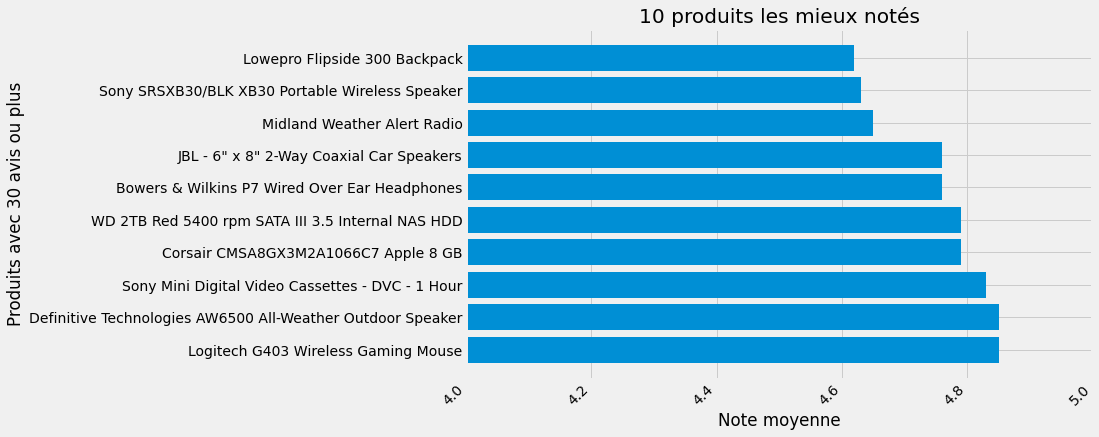

In [10]:
data = {'Logitech G403 Wireless Gaming Mouse': 4.85,
        'Definitive Technologies AW6500 All-Weather Outdoor Speaker': 4.85,
        'Sony Mini Digital Video Cassettes - DVC - 1 Hour': 4.83,
        'Corsair CMSA8GX3M2A1066C7 Apple 8 GB': 4.79,
        'WD 2TB Red 5400 rpm SATA III 3.5 Internal NAS HDD': 4.79,
        'Bowers & Wilkins P7 Wired Over Ear Headphones': 4.76,
        'JBL - 6" x 8" 2-Way Coaxial Car Speakers': 4.76,
        'Midland Weather Alert Radio': 4.65,
        'Sony SRSXB30/BLK XB30 Portable Wireless Speaker': 4.63,
        'Lowepro Flipside 300 Backpack': 4.62}

group_data = list(data.values())
group_names = list(data.keys())
group_mean = np.mean(group_data)

plt.style.use('fast')

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(group_names, group_data)
labels = ax.get_xticklabels()
plt.setp(labels, rotation=45, horizontalalignment='right')
ax.set(xlim=[4, 5], xlabel="Note moyenne", ylabel='Produits avec 30 avis ou plus',
       title='10 produits les mieux notés')

plt.savefig('./Snaps/Plot_03.jpg', bbox_inches = 'tight', transparent=True)

---

### _04 - Marques les plus représentées_

In [11]:
query_04 = pd.read_sql_query("""
    SELECT a.brand, COUNT(a.product_id) as "Nombre de produits"
    FROM manufacturer a
    GROUP BY a.brand
    ORDER BY "Nombre de produits" DESC;
    """, engine)

query_04.head(11)

,brand,Nombre de produits
0,Inconnu,483
1,Sony,22
2,Yamaha,16
3,Pioneer,8
4,Samsung,8
5,YAMAHA,7
6,Apple,7
7,Elitescreens,6
8,Alpine,6
9,Denaq,6


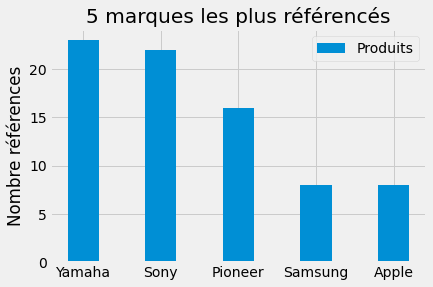

In [12]:
labels = ['Yamaha', 'Sony', 'Pioneer', 'Samsung', 'Apple']
men_means = [23, 22, 16, 8, 8]
men_std = [0, 0, 0, 0, 0]
width = 0.40       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

ax.bar(labels, men_means, width, yerr=men_std, label='Produits')

ax.set_ylabel('Nombre références')
ax.set_title('5 marques les plus référencés')
ax.legend()

plt.savefig('./Snaps/Plot_04.jpg', bbox_inches = 'tight', transparent=True)

plt.show()

---

### _05 - Couleurs les plus présentes_

In [13]:
query_05 = pd.read_sql_query("""
    SELECT a.colors as "Couleur", COUNT(a.colors) as "Nombre de produits"
    FROM product a
    GROUP BY a.colors
    ORDER BY "Nombre de produits" DESC
""", engine)

query_05.head(20)

,Couleur,Nombre de produits
0,Inconnue,812
1,Black,7
2,Multicolor,3
3,"Black,White",2
4,White,2
5,"Gray,Color",1
6,"Navy,Black,Gray,Blue",1
7,"Multicolor,Black,Grey",1
8,Blue,1
9,"Blue,Graphite,Blue steel,Black,Merlot,Blizzard",1


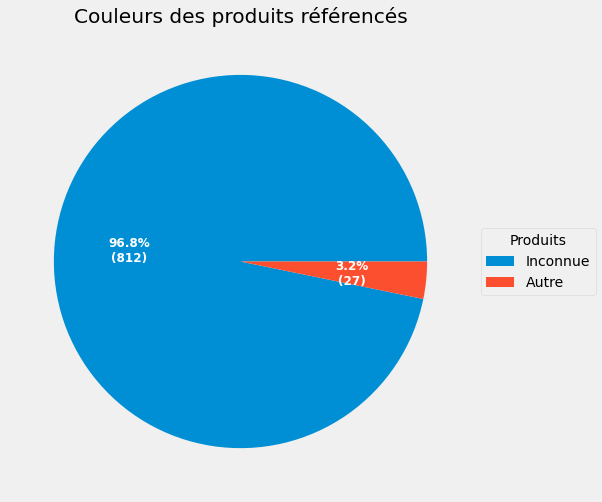

In [14]:
fig, ax = plt.subplots(figsize=(27, 8), subplot_kw=dict(aspect="equal"))

contenu = ["812 Inconnue",
          "27 Autre"]

data = [float(x.split()[0]) for x in contenu]
legende = [x.split()[-1] for x in contenu]


def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)


wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))

ax.legend(wedges, legende,
          title="Produits",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=12, weight="bold")

ax.set_title("Couleurs des produits référencés")

plt.savefig('./Snaps/Plot_05.jpg', bbox_inches = 'tight', transparent=True)

plt.show()

---

### _06 - Pourcentage de produits disponibles_

In [15]:
query_06 = pd.read_sql_query("""
    SELECT a.availability as "Disponibilité", COUNT(a.product_id) as "Nombre de produits"
    FROM prices a
    GROUP BY a.availability 
    ORDER BY "Nombre de produits" DESC
""", engine)

query_06.head(15)

,Disponibilité,Nombre de produits
0,In Stock,3172
1,Yes,2136
2,yes,893
3,TRUE,663
4,Out Of Stock,115
5,Special Order,109
6,More on the Way,91
7,None,50
8,undefined,40
9,sold,22


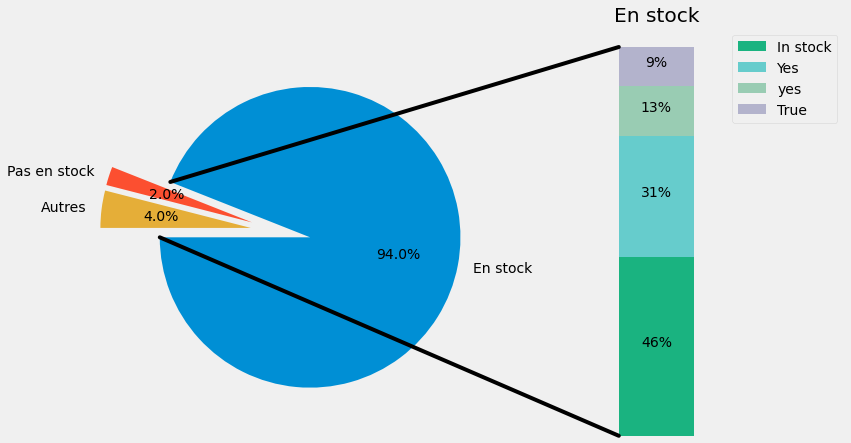

In [16]:
from matplotlib.patches import ConnectionPatch

# make figure and assign axis objects
fig = plt.figure(figsize=(12, 7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
fig.subplots_adjust(wspace=0)

# pie chart parameters
ratios = [94, 2, 4]
labels = ['En stock', 'Pas en stock', 'Autres']
explode = [0.2, 0.2, 0.2]
# rotate so that first wedge is split by the x-axis
angle = -90 * ratios[0]
ax1.pie(ratios, autopct='%1.1f%%', startangle=angle,
        labels=labels, explode=explode)

# bar chart parameters

xpos = 0
bottom = 0
ratios = [.46, .31, .13, .10]
width = .2
colors = [[.1, .7, .5], [.4, .8, .8], [.6, .8, .7], [.7, .7, .8]]

for j in range(len(ratios)):
    height = ratios[j]
    ax2.bar(xpos, height, width, bottom=bottom, color=colors[j])
    ypos = bottom + ax2.patches[j].get_height() / 2
    bottom += height
    ax2.text(xpos, ypos, "%d%%" % (ax2.patches[j].get_height() * 100),
             ha='center')

ax2.set_title('En stock')
ax2.legend(('In stock', 'Yes', 'yes', 'True'))
ax2.axis('off')
ax2.set_xlim(- 2.5 * width, 2.5 * width)

# use ConnectionPatch to draw lines between the two plots
# get the wedge data
theta1, theta2 = ax1.patches[0].theta1, ax1.patches[0].theta2
center, r = ax1.patches[0].center, ax1.patches[0].r
bar_height = sum([item.get_height() for item in ax2.patches])

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
con.set_linewidth(4)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(4)

plt.savefig('./Snaps/Plot_06.jpg', bbox_inches = 'tight', transparent=True)

plt.show()

---

### _07 - Différentes currency_

In [17]:
query_07 = pd.read_sql_query("""
    SELECT a.currency as "Devise", COUNT(a.product_id) as "Nombre"
    FROM prices a
    GROUP BY a.currency 
    ORDER BY "Nombre" DESC
""", engine)

query_07.head()

,Devise,Nombre
0,USD,7248
1,None,50
2,CAD,1


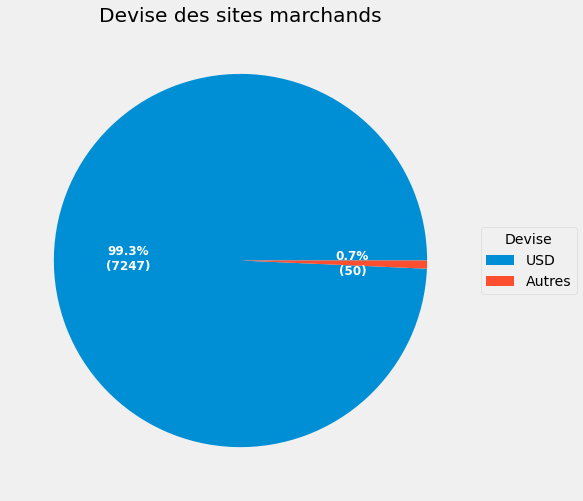

In [33]:
fig, ax = plt.subplots(figsize=(27, 8), subplot_kw=dict(aspect="equal"))

contenu = ["7248 USD",
           "51 Autres"]

data = [float(x.split()[0]) for x in contenu]
legende = [x.split()[-1] for x in contenu]


def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)


wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))

ax.legend(wedges, legende,
          title="Devise",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=12, weight="bold")

ax.set_title("Devise des sites marchands")

plt.savefig('./Snaps/Plot_07.jpg', bbox_inches = 'tight', transparent=True)

plt.show()

---

### _08 - Différentes conditions_

In [19]:
query_08 = pd.read_sql_query("""
    SELECT a.condition as "Etat", COUNT(a.product_id) as "Nombre"
    FROM prices a
    GROUP BY a.condition 
    ORDER BY "Nombre" DESC;
""", engine)

query_08.head(15)

,Etat,Nombre
0,New,6226
1,new,699
2,Used,143
3,New other (see details),92
4,Manufacturer refurbished,55
5,None,50
6,Seller refurbished,15
7,Refurbished,11
8,pre-owned,3
9,refurbished,2


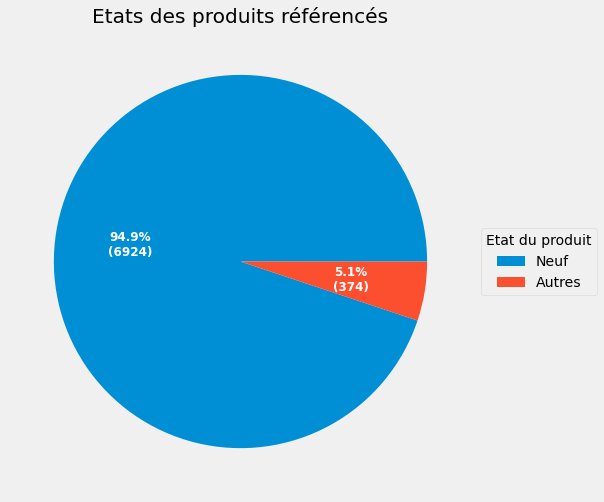

In [20]:
fig, ax = plt.subplots(figsize=(27, 8), subplot_kw=dict(aspect="equal"))

contenu = ["6925 Neuf",
           "374 Autres"]

data = [float(x.split()[0]) for x in contenu]
legende = [x.split()[-1] for x in contenu]


def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)


wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))

ax.legend(wedges, legende,
          title="Etat du produit",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=12, weight="bold")

ax.set_title("Etats des produits référencés")

plt.savefig('./Snaps/Plot_08.jpg', bbox_inches = 'tight', transparent=True)

plt.show()

---

### _09 - Articles les plus chers en moyenne_

In [21]:
query_09 = pd.read_sql_query("""
    SELECT a.name, AVG(b.amountmax)
    FROM product a 
    LEFT JOIN prices b on a.product_id=b.product_id 
    GROUP BY a.name
    HAVING COUNT(b.amountmax) > 5
    ORDER BY AVG(b.amountmax) DESC
    LIMIT 10;
""", engine)

query_09.head(10)

,name,avg
0,Razer - Blade Pro 17.3 4K Ultra HD Touch-Scree...,3975.990112
1,Refurbished Samsung Curved 65 4K (2160P) Smart...,3937.802434
2,Sony - 55 Class - OLED - A1E Series - 2160p - ...,3528.483896
3,LG Electronics OLED65C7P 65-Inch 4K Ultra HD S...,3246.363585
4,LG - 65 Class - OLED - B7A Series - 2160p - Sm...,3123.529222
5,XBR-X850E-Series 75-Class HDR UHD Smart LED TV,2939.151790
6,SunBriteTV - Signature Series - 43 Class - LED...,2799.707136
7,Samsung - 65 Class - LED - Q7F Series - 2160p ...,2699.323324
8,MU9000-Series 65-Class HDR UHD Smart LED TV,2604.316180
9,Samsung - 55 Class - LED - Curved - Q7C Series...,2494.725623


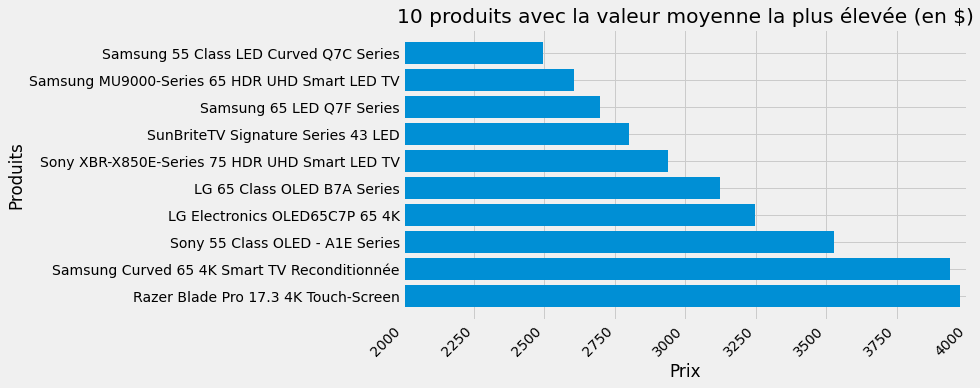

In [22]:
data = {'Razer Blade Pro 17.3 4K Touch-Screen': 3975.99,
        'Samsung Curved 65 4K Smart TV Reconditionnée': 3937.80,
        'Sony 55 Class OLED - A1E Series': 3528.48,
        'LG Electronics OLED65C7P 65 4K': 3246.36,
        'LG 65 Class OLED B7A Series': 3123.52,
        'Sony XBR-X850E-Series 75 HDR UHD Smart LED TV': 2939.15,
        'SunBriteTV Signature Series 43 LED': 2799.70,
        'Samsung 65 LED Q7F Series': 2699.32,
        'Samsung MU9000-Series 65 HDR UHD Smart LED TV': 2604.31,
        'Samsung 55 Class LED Curved Q7C Series': 2494.72}

group_data = list(data.values())
group_names = list(data.keys())
group_mean = np.mean(group_data)

plt.style.use('fast')

fig, ax = plt.subplots(figsize=(9, 5))
ax.barh(group_names, group_data)
labels = ax.get_xticklabels()
plt.setp(labels, rotation=45, horizontalalignment='right')
ax.set(xlim=[2000, 4000], xlabel="Prix", ylabel='Produits',
       title='10 produits avec la valeur moyenne la plus élevée (en $)')

plt.savefig('./Snaps/Plot_09.jpg', bbox_inches = 'tight', transparent=True)

---

### _10 - Articles les moins chers en moyenne_

In [23]:
query_10 = pd.read_sql_query("""
    SELECT a.name, AVG(b.amountmin)
    FROM product a 
    LEFT JOIN prices b on a.product_id=b.product_id 
    GROUP BY a.name
    HAVING COUNT(b.amountmin) > 5
    ORDER BY AVG(b.amountmin) ASC
    LIMIT 10;
""", engine)

query_10.head(10)

,name,avg
0,"Portable Bluetooth Wireless Speaker, Red",13.953333
1,Samsung - Adaptive Fast Charging Wall Charger ...,15.451200
2,"Lowepro Dashpoint AVC 1, Blue",15.826667
3,House of Marley Smile Jamaica In-Ear Earbuds,19.689166
4,PP999 Phono Preamplifier,19.862857
5,DENAQ - AC Power Adapter and Charger for Selec...,20.341667
6,Boytone - Portable Bluetooth Speaker - Blue,23.823333
7,Roll Bar Mount,24.217143
8,DENAQ - AC Power Adapter and Charger for Selec...,26.306667
9,TL-SG108 8-Port 10/100/1000 Mbps Unmanaged Des...,26.347273


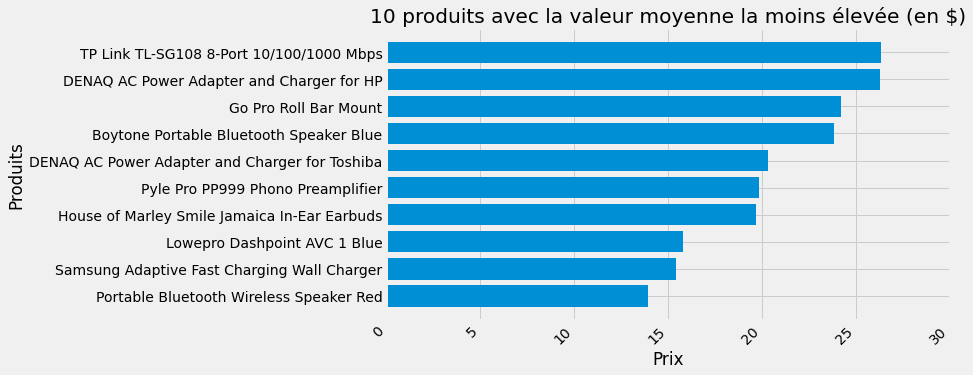

In [24]:
data = {'Portable Bluetooth Wireless Speaker Red': 13.95,
        'Samsung Adaptive Fast Charging Wall Charger': 15.45,
        'Lowepro Dashpoint AVC 1 Blue': 15.82,
        'House of Marley Smile Jamaica In-Ear Earbuds': 19.68,
        'Pyle Pro PP999 Phono Preamplifier': 19.86,
        'DENAQ AC Power Adapter and Charger for Toshiba': 20.34,
        'Boytone Portable Bluetooth Speaker Blue': 23.82,
        'Go Pro Roll Bar Mount': 24.21,
        'DENAQ AC Power Adapter and Charger for HP': 26.30,
        'TP Link TL-SG108 8-Port 10/100/1000 Mbps': 26.34}

group_data = list(data.values())
group_names = list(data.keys())
group_mean = np.mean(group_data)

plt.style.use('fast')

fig, ax = plt.subplots(figsize=(9, 5))
ax.barh(group_names, group_data)
labels = ax.get_xticklabels()
plt.setp(labels, rotation=45, horizontalalignment='right')
ax.set(xlim=[0, 30], xlabel="Prix", ylabel='Produits',
       title='10 produits avec la valeur moyenne la moins élevée (en $)')

plt.savefig('./Snaps/Plot_10.jpg', bbox_inches = 'tight', transparent=True)

---

 ### _11 - Merchant les plus représentés_

In [25]:
query_11 = pd.read_sql_query("""
    SELECT a.merchant as "Site marchand", COUNT(DISTINCT b.product_id) as "Nombre"
    FROM prices a
    LEFT JOIN product b ON a.product_id = b.product_id 
    GROUP BY "Site marchand"
    ORDER BY "Nombre" DESC
""", engine)

query_11.head(10)

,Site marchand,Nombre
0,Bestbuy.com,815
1,bhphotovideo.com,492
2,Walmart.com,234
3,Beach Camera,71
4,None,50
5,AMI Ventures Inc,46
6,Beach Audio Inc,31
7,buydig,31
8,Best Buy,27
9,UnbeatableSale,26


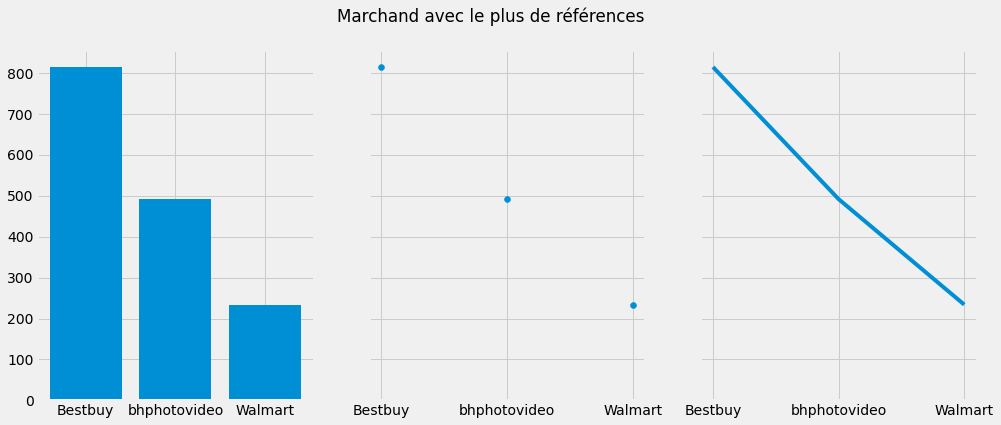

In [26]:
data = {'Bestbuy': 815, 'bhphotovideo': 492, 'Walmart': 234}
names = list(data.keys())
values = list(data.values())

fig, axs = plt.subplots(1, 3, figsize=(15, 6), sharey=True)
axs[0].bar(names, values)
axs[1].scatter(names, values)
axs[2].plot(names, values)
fig.suptitle('Marchand avec le plus de références')

plt.savefig('./Snaps/Plot_11.jpg', bbox_inches = 'tight', transparent=True)

---

### _12 - Nombre de commentaires "Helpful"_

In [27]:
query_12 = pd.read_sql_query("""
    SELECT a.dorecommend as "Recommande le produit", COUNT(a.product_id) as "Nombre"
    FROM reviews a
    GROUP BY "Recommande le produit"
    ORDER BY "Nombre" DESC;
""", engine)

query_12.head(10)

,Recommande le produit,Nombre
0,True,5401
1,None,2226
2,False,507


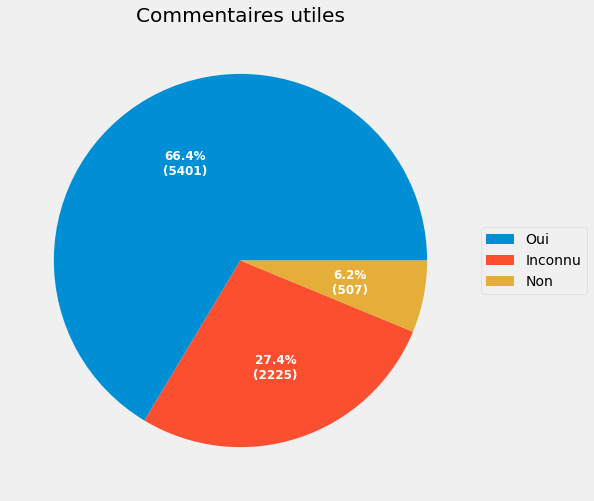

In [28]:
fig, ax = plt.subplots(figsize=(27, 8), subplot_kw=dict(aspect="equal"))

contenu = ["5401 Oui",
           "2226 Inconnu",
           "507 Non"]

data = [float(x.split()[0]) for x in contenu]
legende = [x.split()[-1] for x in contenu]


def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)


wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))

ax.legend(wedges, legende,
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=12, weight="bold")

ax.set_title("Commentaires utiles")

plt.savefig('./Snaps/Plot_12.jpg', bbox_inches = 'tight', transparent=True)

plt.show()

---

### _13 - Username avec le plus d'avis_

In [29]:
query_13 = pd.read_sql_query("""
    SELECT a.username as "Username", COUNT(a.username) as "Nombre"
    FROM reviews a
    GROUP BY "Username"
    ORDER BY "Nombre" desc
    LIMIT 10;
""", engine)

query_13.head(10)

,Username,Nombre
0,ByAmazon Customer,63
1,Mike,21
2,John,16
3,Chris,14
4,James,13
5,Anonymous,13
6,Jeff,12
7,Dave,11
8,Steve,11
9,Bill,11


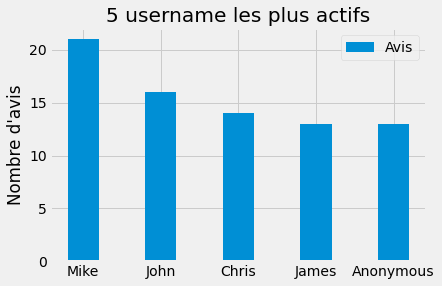

In [30]:
labels = ['Mike', 'John', 'Chris', 'James', 'Anonymous']
men_means = [21, 16, 14, 13, 13]
men_std = [0, 0, 0, 0, 0]
width = 0.40       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

ax.bar(labels, men_means, width, yerr=men_std, label='Avis')

ax.set_ylabel("Nombre d'avis")
ax.set_title('5 username les plus actifs')
ax.legend()

plt.savefig('./Snaps/Plot_13.jpg', bbox_inches = 'tight', transparent=True)

plt.show()

---

### _14 - Comparaison entre les 3 marques les plus représentées et les 3 marchands comptant le plus de références_

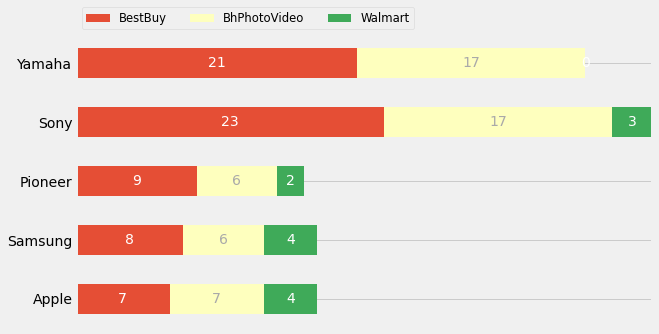

In [31]:
import numpy as np
import matplotlib.pyplot as plt


category_names = ['BestBuy', 'BhPhotoVideo', 'Walmart']
results = {
    'Yamaha': [21, 17, 0],
    'Sony': [23, 17, 3],
    'Pioneer': [9, 6, 2],
    'Samsung': [8, 6, 4],
    'Apple': [7, 7, 4]
}


def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap('RdYlGn')(
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(9.2, 5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=0.5,
                label=colname, color=color)
        xcenters = starts + widths / 2

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        for y, (x, c) in enumerate(zip(xcenters, widths)):
            ax.text(x, y, str(int(c)), ha='center', va='center',
                    color=text_color)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')

    return fig, ax


survey(results, category_names)
plt.savefig('./Snaps/Plot_14.jpg', bbox_inches = 'tight', transparent=True)
plt.show()

---